<a href="https://colab.research.google.com/github/beyg1/Q4/blob/main/Openai%20SDK/Guardrails.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Guardrails
###Two types of Guardrails

1.   Input Guardrails
2.   Output Guardrails



In [ ]:
!pip install -Uq openai-agents pydantic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.9 MB/s eta 0:00:00


In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
from pydantic import BaseModel
from agents import (
    Agent,
    Runner,
    GuardrailFunctionOutput,
    InputGuardrailTripwireTriggered,
    OutputGuardrailTripwireTriggered,
    RunContextWrapper,
    TResponseInputItem,
    input_guardrail,
    output_guardrail,
    AsyncOpenAI,
    OpenAIChatCompletionsModel,
    RunConfig
)
from google.colab import userdata

In [ ]:

gemini_api_key = userdata.get("GOOGLE_API_KEY")


# Check if the API key is present; if not, raise an error
if not gemini_api_key:
    raise ValueError("GEMINI_API_KEY is not set. Please ensure it is defined in your .env file.")

In [ ]:
external_client = AsyncOpenAI(
    api_key=gemini_api_key,
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/",
)

model = OpenAIChatCompletionsModel(
    model="gemini-2.0-flash",
    openai_client=external_client
)

config = RunConfig(
    model=model,
    model_provider=external_client,
    tracing_disabled=True
)


#Implementation of Input Guardrail:
####Checks that the input going into your LLM is "safe" or whatever we want it to be

In [ ]:
class HomeWork_Tripwire(BaseModel):
  is_homework: bool
  reason: str

input_guardrail_agent = Agent(
    name="Guardrail Agent",
    instructions="Check if input is related to homework, as it's not allowed to act on.",
    output_type=HomeWork_Tripwire,
    #config=config
)

@input_guardrail
async def homework_guardrail(
    ctx: RunContextWrapper,
    agent: Agent,
    input: str | list[TResponseInputItem],
) -> GuardrailFunctionOutput:

 result = await Runner.run(input_guardrail_agent, input,context=ctx,run_config=config)

 return GuardrailFunctionOutput(
        result.final_output,
        tripwire_triggered=result.final_output.is_homework,
    )

In [ ]:
agent = Agent(
    name="Customer support agent",
    instructions="You are a customer support agent. You help customers with their questions.",
    input_guardrails=[homework_guardrail],
)

In [ ]:
try:
    result = await Runner.run(agent, "Hello, how are you? can you help me with an assignment?", run_config = config)
    print("Guardrail didn't trip - this is unexpected")
    print(result.final_output)

except InputGuardrailTripwireTriggered:
    print("Math homework guardrail tripped")

Math homework guardrail tripped


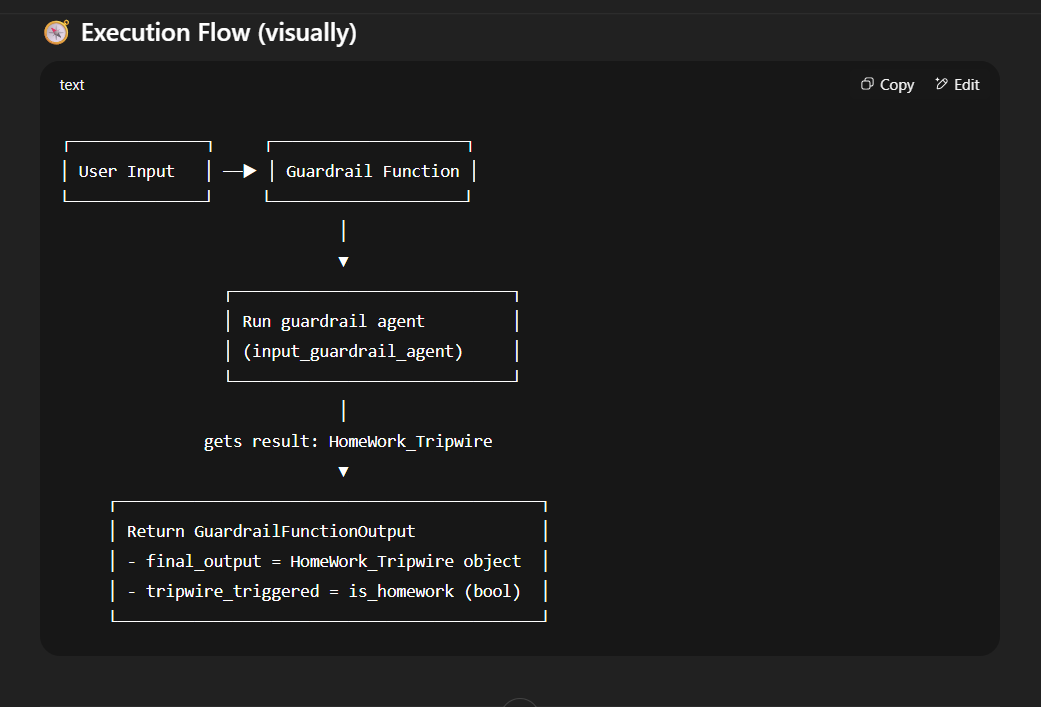

#Implementation of Output Guardrail:
The output guardrail checks that the output from your LLM is "safe".

In [ ]:
class MessageOutput(BaseModel):
    response: str

class MathOutput(BaseModel):
    is_math: bool
    reasoning: str

guardrail_agent2 = Agent(
    name="Guardrail check",
    instructions="Check if the output includes any math.",
    output_type=MathOutput,
)

@output_guardrail
async def math_guardrail2(
    ctx: RunContextWrapper, agent: Agent, output: MessageOutput
) -> GuardrailFunctionOutput:
    result = await Runner.run(guardrail_agent2, output.response, context=ctx.context, run_config = config)

    return GuardrailFunctionOutput(
        output_info=result.final_output,
        tripwire_triggered=result.final_output.is_math,
    )

In [ ]:
agent2 = Agent(
    name="Customer support agent",
    instructions="You are a customer support agent. You help customers with their questions.",
    output_guardrails=[math_guardrail2],
    output_type=MessageOutput,
)

In [ ]:
# This should trip the guardrail
try:
    await Runner.run(agent2, "Hello, can you help me solve for x: 2x + 3 = 11?", run_config = config)
    print("Guardrail didn't trip - this is unexpected")

except OutputGuardrailTripwireTriggered:
    print("Math output guardrail tripped")

Guardrail didn't trip - this is unexpected
